# Surface Water Runoff

This is a simple 1D ramp on which we rain and apply a series of boundary conditions.  Rain flows downhill (to the right in these images), and leaves out the right side boundary.  Note these also show the use of observations, which allow for visualization that is spatially sparse but is evaluated frequently in time.  The most common use of this is hydrographs (which is what we use this for here).

Author: Ethan Coon

In [22]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import colors
import numpy as np
from matplotlib import pyplot as plt
import pandas
import h5py
import pandas as pd

In [10]:
def plot(directory):
    """A generic plotting script plotting ponded depth and discharge/runoff"""
    vis = ats_xdmf.VisFile(directory, domain='surface', time_unit='s')
    vis.loadMesh(order=['x','y'])

    cm = colors.cm_mapper(vis.times[0], vis.times[-1], 'jet')
    x = vis.centroids[:,0]

    fig, ax = plt.subplots(1,2, figsize=(14,3))

    # This simply gets a colorbar axis
    C = [[0,0],[0,0]]
    C3 = ax[0].contourf(C, vis.times, cmap='jet')
    ax[0].cla()  

    pd = vis.getArray('surface-ponded_depth')
    print(pd.shape)
    elev = vis.get('surface-elevation', '0')

    #ax[0].plot(x, elev, 'k')
    for i in range(len(vis.times)):
        #ax[0].plot(x, elev + pd[i,:], color=cm(i))
        ax[0].plot(x, pd[i,:], color=cm(i))

    ax[0].set_xlabel('x-coordinate [m]')
    ax[0].set_ylabel('ponded depth [m]')
    
    hydro = pandas.read_csv(os.path.join(directory, 'surface_outlet_flux.dat'), comment='#')
    ax[1].plot(hydro["time [s]"][:]/60.0, hydro["surface outlet flux"][:], 'b')
    ax[1].set_xlabel('time [min]')
    ax[1].set_ylabel('discharge flow rate [mol/s]')
    
    cbar = plt.colorbar(C3, ax=ax[0])
    cbar.ax.set_ylabel("time [min]")
    
    plt.tight_layout()
    plt.show()


The baseline problem -- this simply rains with no flux boundaries (and hence no discharge).  The rain turns off after 60 minutes, and the simulation continues to drain for 3 hours.  Note the ponded depth plots are a little weird here -- they should probably get updated to plot h + z, i.e. the ponded depth on top of the baseline elevation (the ramp).

(19, 10)


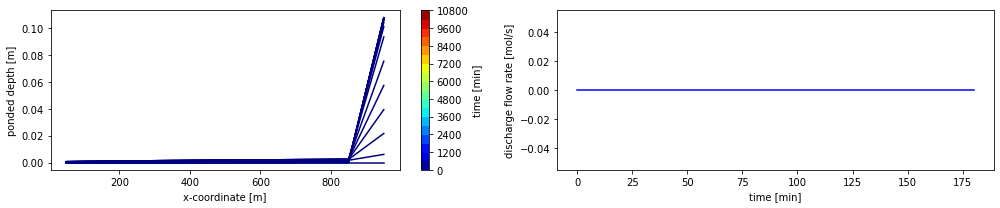

In [11]:
plot("surface_water.demo")

Often it is useful to set a max river stage, or head boundary condition, which lets water out once the head gets above a certain level (e.g. 15 cm here).  In this example, the mesh is so coarse and the domain is sufficiently sloped that the entire domain still drains (the most downhill cell's elevation is more than 15cm about the boundary elevation), but this would not be the case in a higher-resolution or less-sloping run.

(19, 10)


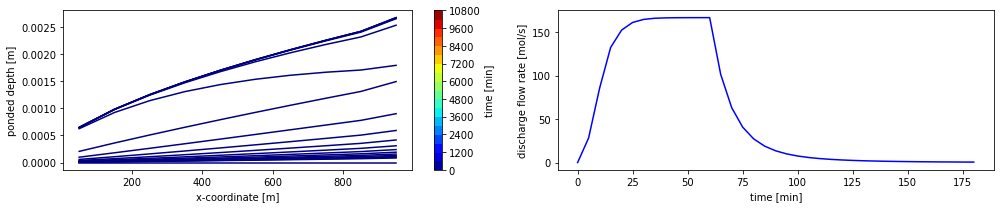

In [12]:
plot("max_head.demo")

There are two other alternatives to setting the max ponded depth at the outlet.  The first is a "zero ponded depth gradient" boundary, where the water level is assumed to parallel the topography.  Note this is really only useful in synthetic cases, where you know that this will not result in water flowing **_into_** the domain.

(19, 10)


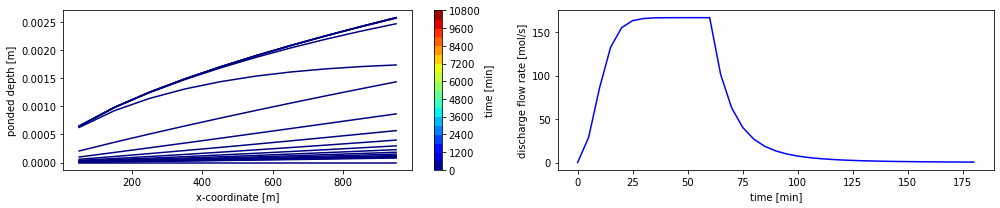

In [13]:
plot("zero_gradient.demo")

Finally, the second is a critical depth boundary condition, which sets the flux based on ponded depth, and is standard in the literature.

$q = n_{liq} h \sqrt{gh}$

or equivalently,

$V = \sqrt{gh}$.

Note that as this goes to zero with zero ponded depth, it takes a long time to drain.

(19, 10)


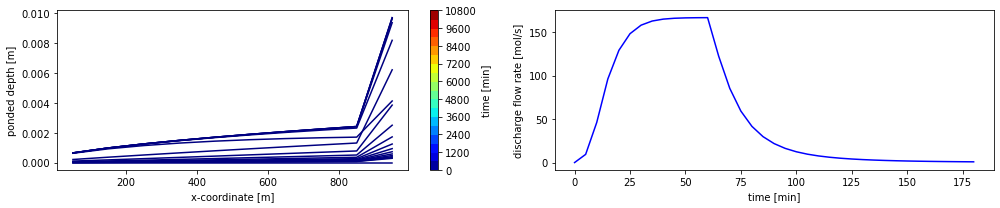

In [14]:
plot("critical_depth.demo")

### Surface flow outputs

In [16]:
file_name = 'max_head.demo'

In [17]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    ponded_depth = hdf.get('surface-ponded_depth.cell.0/100')
    print(ponded_depth)

List of datasets in this file: 
 
 ['surface-aspect.cell.0', 'surface-cell_volume.cell.0', 'surface-elevation.cell.0', 'surface-manning_coefficient.cell.0', 'surface-mass_density_liquid.cell.0', 'surface-mass_source.cell.0', 'surface-molar_density_liquid.cell.0', 'surface-overland_conductivity.cell.0', 'surface-ponded_depth.cell.0', 'surface-ponded_depth_bar.cell.0', 'surface-pres_elev.cell.0', 'surface-pressure.cell.0', 'surface-slope_magnitude.cell.0', 'surface-source_molar_density.cell.0', 'surface-temperature.cell.0', 'surface-velocity.cell.0', 'surface-velocity.cell.1', 'surface-velocity.cell.2', 'surface-water_content.cell.0', 'surface-water_content_bar.cell.0']


None


In [18]:
def input_datavarsurface(file_name, variable):
    """
        Define once more!
    """
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        data_var = pd.DataFrame(columns=time_period)
    
    with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:

        for i in time_period[1:]:
            var = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var_all = var.flatten()
            data_var[i] = var_all
            
    data_var = data_var.transpose()
            #data_var = pd.DataFrame(index=time_period[i],data=var)
    
    return data_var

In [23]:
file_name = 'max_head.demo'
variable = 'surface-surface_subsurface_flux'
surface_ponded_depth = input_datavarsurface(file_name,variable)

#surface_ponded_depth.columns = np.arange(0,201,1)
surface_ponded_depth

,0
0,NaN
8,None
11,None
13,None
15,None
17,None
19,None
21,None
23,None
25,None


<AxesSubplot:>

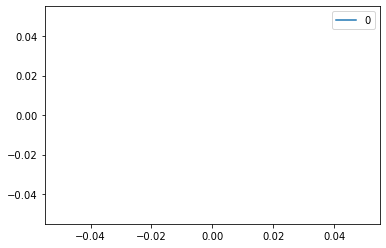

In [24]:
surface_ponded_depth.plot()

In [ ]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        
    
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        print(var_0)

In [ ]:
data_var = pd.DataFrame(columns=time_period)
data_var[0] = var_all
data_var

In [ ]:
type(var_all)

In [ ]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        data_var = pd.DataFrame(columns=time_period)
    
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:

        for i in time_period[1:]:
            var = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var_all = var.flatten()
            data_var[i] = var_all
            #data_var = pd.DataFrame(index=time_period[i],data=var)
print(data_var)     

In [ ]:
type(data_var[0])

In [ ]:
variable = 'surface-water_content'
surface_ponded_depth = input_datavarsurface(file_name,variable)

surface_ponded_depth.columns = np.arange(0,201,1)
surface_ponded_depth

In [ ]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        z = np.arange(0.0, 10, 0.1)
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/100'))
        var_0 = var_all_0.flatten()
        print(var_0)